# Define the location for the data set and Glove for embedding


In [1]:
# The folder of the data set
dataset_path = '../data/raw/detection/DailyDialog/dailydialog'
# The folder for the models
model_path = '../models'
# The folder where Glove is installed
TORCHNLP_CACHEDIR = f'{model_path}/Glove/pytorch-nlp_data'

# Define the Global Variables


In [68]:
isTrain = True
seed = 2
train_data_path = f"{dataset_path}/train/dialogues_train.txt"
train_label_path = f"{dataset_path}/train/dialogues_emotion_train.txt"
dev_data_path = f"{dataset_path}/validation/dialogues_validation.txt"
dev_label_path = f"{dataset_path}/validation/dialogues_emotion_validation.txt"
test_data_path = f"{dataset_path}/test/dialogues_test.txt"
test_label_path = f"{dataset_path}/test/dialogues_emotion_test.txt"
train_preprocess = f"{dataset_path}/train/dialogues_train_preprocess.pkl"
dev_preprocess = f"{dataset_path}/validation/dialogues_validation_preprocess.pkl"
test_preprocess = f"{dataset_path}/test/dialogues_test_preprocess.pkl"
model_save_path = f"{model_path}/dailyDialog/model_test_new_code.pt"
batch_size = 16
embedding_size = 300
lstm_hidden_size = 500
hidden_layer_size = 512
learning_rate = 0.001
epochs = 3
num_classes = 7

# Imports


In [3]:
!pip install pytorch-nlp --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet
!pip install scikit-learn --quiet
!pip install pyspellchecker --quiet
!pip install contractions --quiet
!pip install beautifulsoup4 --quiet
!pip install emoji --quiet
!pip install matplotlib --quiet

In [80]:
from typing import List, Tuple, Callable, Dict
import argparse
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import torch.autograd
import torch.optim as optim
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, classification_report, confusion_matrix)
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence
from torchnlp.word_to_vector import GloVe
import contractions
import unicodedata
from bs4 import BeautifulSoup
import emoji
import re
from spellchecker import SpellChecker
import pickle
import os
import matplotlib.pyplot as plt
import threading

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# define Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define Glove
pretrained_wv = GloVe(cache=TORCHNLP_CACHEDIR)
# Stopword removal
stop_words = set(stopwords.words('english'))
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to C:\Users\Ahmed-
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ahmed-
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ahmed-
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ahmed-Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
print(DEVICE)

cuda


# helper functions


In [7]:
def dump_tuple(filename: str, data: tuple) -> None:
    '''
    Dump the tuple to a file.
    :param filename: The name of the file to dump the tuple to.
    :type filename: str
    :param data: The tuple to dump.
    :type data: tuple
    '''
    with open(filename, 'wb') as file:
        pickle.dump(data, file)


def load_tuple(filename: str) -> tuple:
    '''
    Load the tuple from the file.
    :param filename: The name of the file to load the tuple from.
    :type filename: str
    :return: The loaded tuple.
    :rtype: tuple
    '''
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Preparing the Data set


In [8]:
def clean_train(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    # translate emojis
    line = translate_emojis_to_text(line)
    # lower the line
    line = lower_sentence(line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    # remove emails
    line = remove_emails(line)
    # remove html
    line = clean_html(line)
    # remove urls
    line = remove_url(line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    # expand
    line = expand_sentence(line)
    # remove possessives
    line = remove_possessives(line)
    # remove extra spaces
    line = remove_extra_space(line)
    # tekonize
    line = tokenize_sentence(line)
    # remove stopwords
    line = remove_stop_words(line)
    # lemmetization
    line = lemm_sentence(line)
    if len(line) == 0:
        return ['Normal']
    return line

In [9]:
def clean(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    # translate emojis
    line = translate_emojis_to_text(line)
    # lower the line
    line = lower_sentence(line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    # remove emails
    line = remove_emails(line)
    # remove html
    line = clean_html(line)
    # remove urls
    line = remove_url(line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    # expand
    line = expand_sentence(line)
    # remove possessives
    line = remove_possessives(line)
    # remove extra spaces
    line = remove_extra_space(line)
    # tekonize
    line = tokenize_sentence(line)
    # check spelling
    line = check_sentence_spelling(line)
    # remove stopwords
    line = remove_stop_words(line)
    # lemmetization
    line = lemm_sentence(line)
    if len(line) == 0:
        return ['Normal']
    return line

In [10]:
def clean_steps(line: str) -> list[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    print('-------------------------------')
    # translate emojis
    line = translate_emojis_to_text(line)
    print("After translate --> ", line)
    # lower the line
    line = lower_sentence(line)
    print("After lower --> ", line)
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    print("After remoeve non ascii --> ", line)
    line = remove_emails(line)
    print("After remove email --> ", line)
    # remove html
    line = clean_html(line)
    print("After remove html --> ", line)
    # remove urls
    line = remove_url(line)
    print("After remove url --> ", line)
    # replace repeated chars
    line = replace_repeated_chars(line)
    print("replace repeated chars --> ", line)
    # expand
    line = expand_sentence(line)
    print("After expand --> ", line)
    # remove possessives
    line = remove_possessives(line)
    print("After remove possessives --> ", line)
    # remove extra spaces
    line = remove_extra_space(line)
    print("After remove extra space --> ", line)
    # tekonize
    line = tokenize_sentence(line)
    print("After tokenize --> ", line)
    # check spelling
    line = check_sentence_spelling(line)
    print("After spelling check --> ", line)
    # remove stopwords
    line = remove_stop_words(line)
    print("After remove stop words --> ", line)
    # lemmetization
    line = lemm_sentence(line)
    print("After lemmatization --> ", line)
    print('-------------------------------')
    if len(line) == 0:
        print(['Normal'])
        return ['Normal']
    return line

In [11]:

def read_dataset_dailyDialog_old(data_path: str, label_path: str) -> Tuple[List[List[List[str]]], List[List[int]]]:
    '''
    Take the data path and the label path and read them.
    It then splits the conversations and extracts each conversation, sentence, and words of each sentence.
    It reads the labels of each sentence in the conversation

    :param data_path: The path of the conversations.
    :type data_path: str
    :param label_path: The path of the labels for the conversations.
    :type label_path: str
    :return: A tuple containing inputs and targets.
             inputs: List of conversations, where each conversation is a list of sentences,
                     and each sentence is a list of words.
             targets: List of labels for each conversation.
    :rtype: tuple
    '''
    # define inputs list
    inputs = []
    # define targets list
    targets = []
    # read data file
    with open(data_path, "r", encoding="utf8") as file_data:
        inputs = [
            [sentence.split(" ") for sentence in line.strip(
                "\n").strip(" __eou__").split(" __eou__")]
            for line in file_data
        ]
        # for loop version
        # for line in file_data:
        #   _sentences = line.strip("\n").strip(" __eou__").split(" __eou__")
        #   sentences = []
        #   for sentence in _sentences:
        #     words = sentence.split(" ")
        #     sentences.append(words)
        #   inputs.append(sentences)
    # read labels file
    with open(label_path, "r", encoding="utf8") as file_data:
        targets = [[int(label) for label in line.strip(
            "\n").strip(" ").split(" ")] for line in file_data]
        # for loop version
        # for line in file_data:
        #     labels = [int(label) for label in line.strip("\n").strip(" ").split(" ")]
        #     targets.append(labels)

    return (inputs, targets)

In [12]:
def read_dialogue_data(file_path: str) -> List[List[str]]:
    '''
    Read the dialogue data from the file path.
    :param file_path: The path of the file.
    :type file_path: str
    :return: A list of dialogues, where each dialogue is a list of sentences,
             and each sentence is a string.
    :rtype: list
    '''
    # define dialogues list
    dialogues = []
    # read data file
    with open(file_path, "r", encoding="utf8") as file_data:
        dialogues = [
            [
                sentence.replace(".", " . ").replace("?", " ? ").replace("!", " ! ").replace(
                    ";", " ; ").replace(":", " : ").replace(",", " , ").strip()
                for sentence in line.split("__eou__") if sentence.strip()
            ]
            for line in file_data
        ]
    return dialogues

In [13]:
def lower_sentence(sentence: str) -> str:
    '''
    Lowercase the sentence.
    :param data: The sentence to lowercase.
    :return: The lowercased sentence
    :rtype: str
    '''
    return sentence.lower()

In [14]:
def remove_emails(sentence: str) -> str:
    '''
    Remove emails from the sentence.
    :param sentence: The sentence to remove emails from.
    :type sentence: str
    :return: The sentence without emails.
    :rtype: str
    '''
    return re.sub(r"\S*@\S*\s?", "", sentence)

In [15]:
def remove_nonascii_diacritic(sentence: str) -> str:
    '''

    Remove diacritics from the sentence.

    :param sentence: The sentence to remove diacritics from.

    :type sentence: str

    :return: The sentence without diacritics.

    :rtype: str
    '''

    return unicodedata.normalize("NFKD", sentence).encode("ascii", "ignore").decode("utf-8", "ignore")

In [16]:
def clean_html(sentence: str) -> str:
    '''
    Remove HTML tags from the sentence.
    :param sentence: The sentence to remove HTML tags from.
    :type sentence: str
    :return: The sentence without HTML tags.
    :rtype: str
    '''
    return BeautifulSoup(sentence, "html.parser").get_text()

In [17]:
def replace_repeated_chars(sentence: str) -> str:
    '''
    Replace repeated characters in the sentence.
    :param sentence: The sentence to replace repeated characters in.
    :type sentence: str
    :return: The sentence with replaced repeated characters.
    :rtype: str
    '''
    # Replace consecutive occurrences of ',', '!', '.', and '?' with a single occurrence
    return re.sub(r'([,!?.])\1+', r'\1', sentence)

In [18]:
def translate_emojis_to_text(sentence: str) -> str:
    '''
    Translate emojis in the sentence to text.
    :param sentence: The sentence to translate emojis to text.
    :type sentence: str
    :return: The sentence with translated emojis to text.
    :rtype: str
    '''
    # Translate emojis to text codes
    translated_text = emoji.demojize(sentence)
    # Remove colons from the translated text
    translated_text = re.sub(r':', '', translated_text)
    return translated_text

In [19]:
def expand_sentence(sentence: str) -> str:
    '''
    Expand the contractions in the sentence.
    :param sentence: The sentence to expand contractions in.
    :type sentence: str
    :return: The sentence with expanded contractions.
    :rtype: str
    '''
    return contractions.fix(sentence)

In [20]:
def remove_url(sentence: str) -> str:
    '''
    Remove URLs from the sentence.
    :param sentence: The sentence to remove URLs from.
    :type sentence: str
    :return: The sentence without URLs.
    :rtype: str
    '''
    return re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?", '', sentence)

In [21]:
def remove_possessives(sentence: str) -> str:
    '''
    Strip possessives from the sentence.
    :param sentence: The sentence to strip possessives from.
    :type sentence: str
    :return: The sentence without possessives.
    :rtype: str
    '''
    # Stripping the possessives
    sentence = sentence.replace("'s", '')
    sentence = sentence.replace('’s', '')
    sentence = sentence.replace('s’', 's')
    sentence = sentence.replace("s'", 's')
    return sentence

In [22]:
def remove_extra_space(sentence: str) -> str:
    '''
    Remove extra spaces from the sentence.
    :param sentence: The sentence to remove extra spaces from.
    :type sentence: str
    :return: The sentence without extra spaces.
    :rtype: str
    '''
    return re.sub(r'\s+', ' ', sentence).strip()

In [23]:
def check_sentence_spelling(sentence: list[str]) -> list[str]:
    '''
    Check the spelling of the words in the sentence.
    :param sentence: The sentence to check the spelling of.
    :type sentence: list
    :return: The sentence with corrected spelling.
    :rtype: list
    '''
    spell = SpellChecker()
    corrected_sentence = []
    for word in sentence:
        if word != '':
            correction = spell.correction(word)
            if correction is not None:
                corrected_sentence.append(correction)
            else:
                corrected_sentence.append(word)
        else:
            corrected_sentence.append('')
    return corrected_sentence

In [24]:
def tokenize_sentence(sentence: str) -> list[str]:
    '''
    Tokenize the sentence.
    :param sentence: The sentence to tokenize.
    :type sentence: str
    :return: The tokenized sentence.
    :rtype: str
    '''
    return nltk.word_tokenize(sentence)

In [25]:
def remove_stop_words(sentence: list[str]) -> list[str]:
    '''
    Remove stop words from the sentence.
    :param sentence: The sentence to remove stop words from.
    :type sentence: list[str]
    :return: The sentence without stop words.
    :rtype: list[str]
    '''
    return [word for word in sentence if word not in stop_words]

In [26]:
def lemm_sentence(sentence: list[str]) -> list[str]:
    '''
    Lemmatize the sentence.
    :param sentence: The sentence to lemmatize.
    :type sentence: list[str]
    :return: The lemmatized sentence.
    :rtype: list[str]
    '''
    # Perform POS tagging
    pos_tags = pos_tag(sentence)
    # Lemmatize each word based on its POS tag
    lemmatized_words = []
    for word, pos in pos_tags:
        # Map Penn Treebank POS tags to WordNet POS tags
        if pos.startswith('N'):  # Nouns
            pos = 'n'
        elif pos.startswith('V'):  # Verbs
            pos = 'v'
        elif pos.startswith('J'):  # Adjectives
            pos = 'a'
        elif pos.startswith('R'):  # Adverbs
            pos = 'r'
        else:
            pos = 'n'  # Default to noun if POS tag not found

        # Lemmatize the word using the appropriate POS tag
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemma)
    return lemmatized_words

In [27]:

def read_dataset_dailyDialog(data_path: str, label_path: str) -> Tuple[List[List[List[str]]], List[List[int]]]:
    '''
    Take the data path and the label path and read them.
    It then splits the conversations and extracts each conversation, sentence, and words of each sentence.
    It reads the labels of each sentence in the conversation

    :param data_path: The path of the conversations.
    :type data_path: str
    :param label_path: The path of the labels for the conversations.
    :type label_path: str
    :return: A tuple containing inputs and targets.
             inputs: List of conversations, where each conversation is a list of sentences,
                     and each sentence is a list of words.
             targets: List of labels for each conversation.
    :rtype: tuple
    '''
    # define targets list
    targets = []
    # read labels file
    with open(label_path, "r", encoding="utf8") as file_data:
        targets = [[int(label) for label in line.strip(
            "\n").strip(" ").split(" ")] for line in file_data]
        # for loop version
        # for line in file_data:
        #     labels = [int(label) for label in line.strip("\n").strip(" ").split(" ")]
        #     targets.append(labels)

    # read data file
    dialogues = read_dialogue_data(data_path)
    # define inputs list
    inputs = [
        [
            clean_train(sentence) for sentence in dialogue
        ]
        for dialogue in dialogues
    ]
    return (inputs, targets)

In [28]:
from joblib import Parallel, delayed


def read_dataset_dailyDialog_threads(data_path: str, label_path: str) -> Tuple[List[List[List[str]]], List[List[int]]]:
    '''
    Take the data path and the label path and read them.
    It then splits the conversations and extracts each conversation, sentence, and words of each sentence.
    It reads the labels of each sentence in the conversation

    :param data_path: The path of the conversations.
    :type data_path: str
    :param label_path: The path of the labels for the conversations.
    :type label_path: str
    :return: A tuple containing inputs and targets.
             inputs: List of conversations, where each conversation is a list of sentences,
                     and each sentence is a list of words.
             targets: List of labels for each conversation.
    :rtype: tuple
    '''
    # read labels file
    with open(label_path, "r", encoding="utf8") as file_data:
        targets = [[int(label) for label in line.strip(
            "\n").strip(" ").split(" ")] for line in file_data]

    # read data file
    dialogues = read_dialogue_data(data_path)

    # Define function to clean sentences
    def clean_sentences(dialogue):
        return [clean(sentence) for sentence in dialogue]

    # Process data (parallelizing sentence cleaning)
    inputs = Parallel(n_jobs=-1)(
        delayed(clean_sentences)(dialogue) for dialogue in dialogues
    )

    return (inputs, targets)

### Test for dataset reading


In [29]:
import time



def clean_time(line: str) -> List[str]:
    '''
    Clean the line and return it as a list of tokens
    :param line: the line to clean
    :type line: str
    :return: the cleaned line as a list of tokens
    :rtype: list
    '''
    start_time = time.time()

    # translate emojis
    line = translate_emojis_to_text(line)
    print("Time taken for translating emojis:", time.time() - start_time)

    start_time = time.time()
    # lower the line
    line = lower_sentence(line)
    print("Time taken for lowering sentence:", time.time() - start_time)

    start_time = time.time()
    # remove non ascii
    line = remove_nonascii_diacritic(line)
    print("Time taken for removing non-ascii characters:",
          time.time() - start_time)

    start_time = time.time()
    # remove emails
    line = remove_emails(line)
    print("Time taken for removing emails:", time.time() - start_time)

    start_time = time.time()
    # remove html
    line = clean_html(line)
    print("Time taken for cleaning HTML:", time.time() - start_time)

    start_time = time.time()
    # remove urls
    line = remove_url(line)
    print("Time taken for removing URLs:", time.time() - start_time)

    start_time = time.time()
    # replace repeated chars
    line = replace_repeated_chars(line)
    print("Time taken for replacing repeated characters:",
          time.time() - start_time)

    start_time = time.time()
    # expand
    line = expand_sentence(line)
    print("Time taken for expanding sentence:", time.time() - start_time)

    start_time = time.time()
    # remove possessives
    line = remove_possessives(line)
    print("Time taken for removing possessives:", time.time() - start_time)

    start_time = time.time()
    # remove extra spaces
    line = remove_extra_space(line)
    print("Time taken for removing extra spaces:", time.time() - start_time)

    start_time = time.time()
    # tokenize
    line = tokenize_sentence(line)
    print("Time taken for tokenization:", time.time() - start_time)

    start_time = time.time()
    # # check spelling
    line = check_sentence_spelling(line)
    print("Time taken for checking spelling:", time.time() - start_time)

    start_time = time.time()
    # remove stopwords
    line = remove_stop_words(line)
    print("Time taken for removing stopwords:", time.time() - start_time)

    start_time = time.time()
    # lemmatization
    line = lemm_sentence(line)
    print("Time taken for lemmatization:", time.time() - start_time)

    return line

In [30]:
if isTrain:
    # Read data
    dialogues_test = read_dialogue_data(train_data_path)
    start_time = time.time()
    d1 = [clean_steps(sen) for sen in dialogues_test[1]]
    print("total", time.time() - start_time)
    print("len", len(dialogues_test))

-------------------------------
After translate -->  Can you do push-ups  ?
After lower -->  can you do push-ups  ?
After remoeve non ascii -->  can you do push-ups  ?
After remove email -->  can you do push-ups  ?
After remove html -->  can you do push-ups  ?
After remove url -->  can you do push-ups  ?
replace repeated chars -->  can you do push-ups  ?
After expand -->  can you do push-ups  ?
After remove possessives -->  can you do push-ups  ?
After remove extra space -->  can you do push-ups ?
After tokenize -->  ['can', 'you', 'do', 'push-ups', '?']


After spelling check -->  ['can', 'you', 'do', 'pushups', '?']
After remove stop words -->  ['pushups', '?']
After lemmatization -->  ['pushup', '?']
-------------------------------
-------------------------------
After translate -->  Of course I can  .  It's a piece of cake  !  Believe it or not  ,  I can do 30 push-ups a minute  .
After lower -->  of course i can  .  it's a piece of cake  !  believe it or not  ,  i can do 30 push-ups a minute  .
After remoeve non ascii -->  of course i can  .  it's a piece of cake  !  believe it or not  ,  i can do 30 push-ups a minute  .
After remove email -->  of course i can  .  it's a piece of cake  !  believe it or not  ,  i can do 30 push-ups a minute  .
After remove html -->  of course i can  .  it's a piece of cake  !  believe it or not  ,  i can do 30 push-ups a minute  .
After remove url -->  of course i can  .  it's a piece of cake  !  believe it or not  ,  i can do 30 push-ups a minute  .
replace repeated chars -->  of course i can  .  it

In [31]:
if isTrain:
    inputs_old, targets_old = read_dataset_dailyDialog_old(
        train_data_path, train_label_path)
    print(inputs_old[0])
    print(targets_old[0])

[['Say', ',', 'Jim', ',', 'how', 'about', 'going', 'for', 'a', 'few', 'beers', 'after', 'dinner', '?'], ['', 'You', 'know', 'that', 'is', 'tempting', 'but', 'is', 'really', 'not', 'good', 'for', 'our', 'fitness', '.'], ['', 'What', 'do', 'you', 'mean', '?', 'It', 'will', 'help', 'us', 'to', 'relax', '.'], ['', 'Do', 'you', 'really', 'think', 'so', '?', 'I', "don't", '.', 'It', 'will', 'just', 'make', 'us', 'fat', 'and', 'act', 'silly', '.', 'Remember', 'last', 'time', '?'], ['', 'I', 'guess', 'you', 'are', 'right.But', 'what', 'shall', 'we', 'do', '?', 'I', "don't", 'feel', 'like', 'sitting', 'at', 'home', '.'], ['', 'I', 'suggest', 'a', 'walk', 'over', 'to', 'the', 'gym', 'where', 'we', 'can', 'play', 'singsong', 'and', 'meet', 'some', 'of', 'our', 'friends', '.'], ['', "That's", 'a', 'good', 'idea', '.', 'I', 'hear', 'Mary', 'and', 'Sally', 'often', 'go', 'there', 'to', 'play', 'pingpong.Perhaps', 'we', 'can', 'make', 'a', 'foursome', 'with', 'them', '.'], ['', 'Sounds', 'great', 'to

In [32]:
if isTrain:
    inputs2, targets2 = read_dataset_dailyDialog(
        train_data_path, train_label_path)
    print(inputs2[0])
    print(targets2[0])

C:\Users\Ahmed-Laptop\AppData\Local\Temp\ipykernel_19120\964458276.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()


[['say', ',', 'jim', ',', 'go', 'beer', 'dinner', '?'], ['know', 'tempt', 'really', 'good', 'fitness', '.'], ['mean', '?', 'help', 'u', 'relax', '.'], ['really', 'think', '?', '.', 'make', 'u', 'fat', 'act', 'silly', '.', 'remember', 'last', 'time', '?'], ['guess', 'right', '.', 'shall', '?', 'feel', 'like', 'sit', 'home', '.'], ['suggest', 'walk', 'gym', 'play', 'singsong', 'meet', 'friend', '.'], ['good', 'idea', '.', 'hear', 'mary', 'sally', 'often', 'go', 'play', 'pingpong', '.', 'perhaps', 'make', 'foursome', '.'], ['sound', 'great', '!', 'willing', ',', 'could', 'ask', 'go', 'dance', 'u', '.', 'excellent', 'exercise', 'fun', ',', '.'], ['good', '.', 'let', "'", 'go', '.'], ['right', '.']]
[0, 0, 0, 0, 0, 0, 4, 4, 4, 4]


In [33]:
if isTrain:
    assert len(inputs_old) == len(targets_old)
    assert len(inputs2) == len(targets2)
    assert len(inputs_old) == len(inputs2)
    assert targets_old == targets2

In [34]:
if isTrain:
    if not os.path.exists(train_preprocess):
        print("Preprocessing the training data")
        dump_tuple(train_preprocess, (inputs2, targets2))
    else:
        print("The preprocessed train data already exists")

Preprocessing the training data


In [35]:
if isTrain:
    # Read data
    dialogues_test = read_dialogue_data(train_data_path)
    d1 = [clean_steps(sen) for sen in dialogues_test[0]]
    print(d1)

-------------------------------
After translate -->  Say  ,  Jim  ,  how about going for a few beers after dinner  ?
After lower -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remoeve non ascii -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remove email -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remove html -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remove url -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
replace repeated chars -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After expand -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remove possessives -->  say  ,  jim  ,  how about going for a few beers after dinner  ?
After remove extra space -->  say , jim , how about going for a few beers after dinner ?
After tokenize -->  ['say', ',', 'jim', ',', 'how', 'about', 'going', 'for', 'a', 'few', 'b

# preprocess the data set (Train, Validation, Test) if not preprocessed


In [36]:
if isTrain:
    if not os.path.exists(train_preprocess):
        print("Preprocessing the training data")
        inputs, targets = read_dataset_dailyDialog(
            train_data_path, train_label_path)
        dump_tuple(train_preprocess, (inputs, targets))
    else:
        print("The preprocessed train data already exists")

The preprocessed train data already exists


In [37]:
if isTrain:
    if not os.path.exists(dev_preprocess):
        print("Preprocessing the validation data")
        inputs, targets = read_dataset_dailyDialog(
            dev_data_path, dev_label_path)
        dump_tuple(dev_preprocess, (inputs, targets))
    else:
        print("The preprocessed dev data already exists")

Preprocessing the validation data


C:\Users\Ahmed-Laptop\AppData\Local\Temp\ipykernel_19120\964458276.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()


In [38]:
if not os.path.exists(test_preprocess):
    print("Preprocessing the testing data")
    inputs, targets = read_dataset_dailyDialog(test_data_path, test_label_path)
    dump_tuple(test_preprocess, (inputs, targets))
else:
    print("The preprocessed test data already exists")

Preprocessing the testing data


C:\Users\Ahmed-Laptop\AppData\Local\Temp\ipykernel_19120\964458276.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(sentence, "html.parser").get_text()


# load the data (train, val, test)


In [39]:
if isTrain:
    # load data (train, dev, test)
    train_data, train_label = load_tuple(train_preprocess)
    dev_data, dev_label = load_tuple(dev_preprocess)
test_data, test_label = load_tuple(test_preprocess)
if isTrain:
    # print length of each
    print("train data length: ", len(train_data), len(train_label))
    print("dev data length: ", len(dev_data), len(dev_label))
print("test data length: ", len(test_data), len(test_label))

train data length:  11118 11118
dev data length:  1000 1000
test data length:  1000 1000


# Analysis on the data (DailyDialoge)


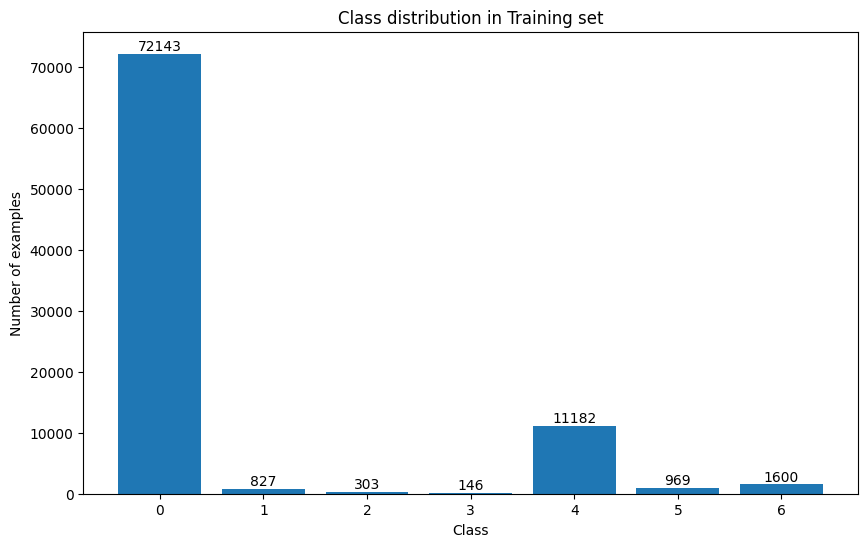

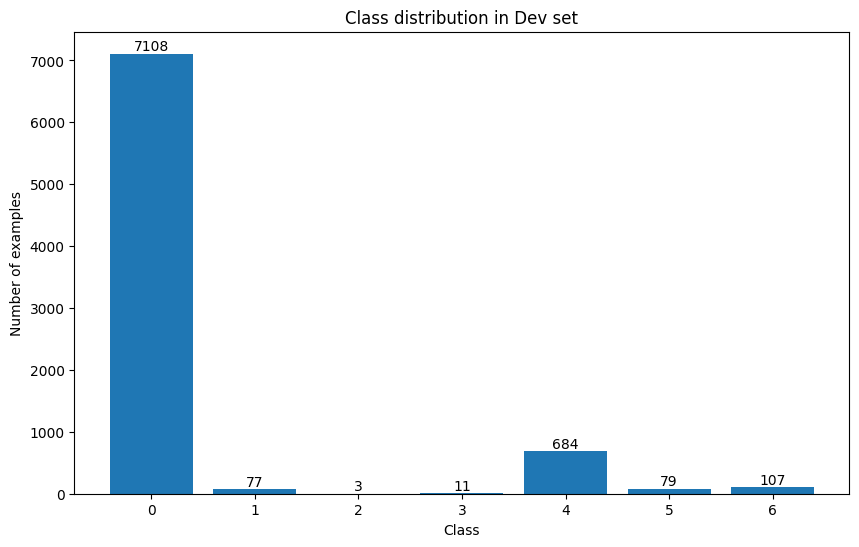

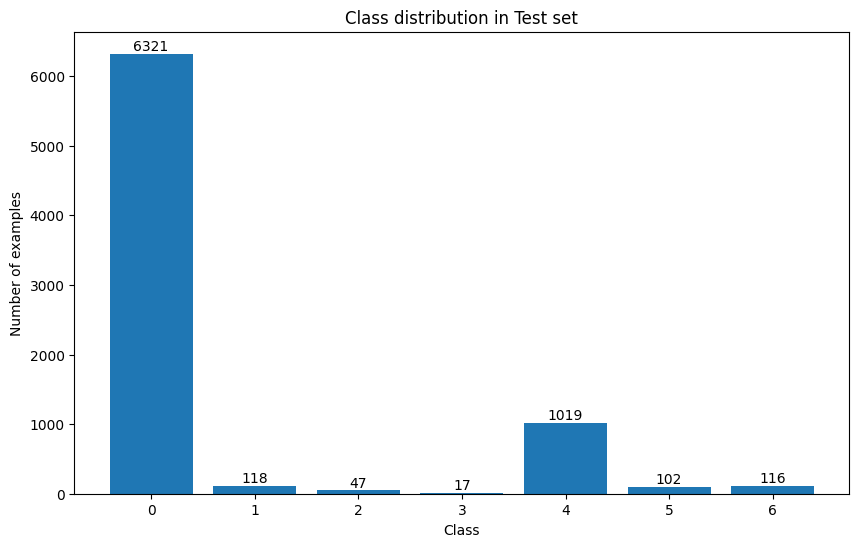

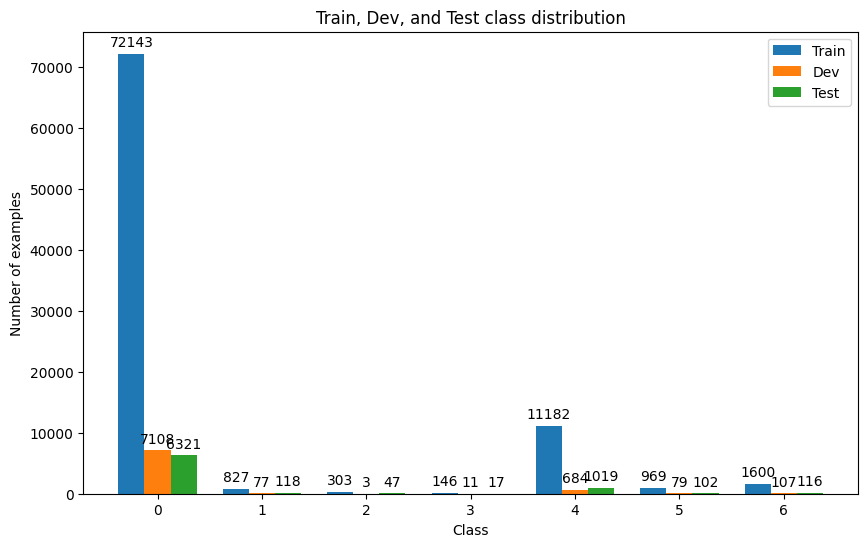

In [40]:
def analyze_class_distribution(targets: List[List[int]], dataset_name: str) -> None:
    '''
    Analyze the class distribution in the dataset.
    :param targets: The list of targets in the dataset.
    :type targets: List[List[int]]
    :param dataset_name: The name of the dataset.
    :type dataset_name: str
    '''
    class_counts = {}
    for target_list in targets:
        for label in target_list:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of examples')
    plt.title(f'Class distribution in {dataset_name}')

    # Annotate each bar with its count
    for label, count in class_counts.items():
        plt.text(label, count, str(count), ha='center', va='bottom')

    plt.show()


def analyze_train_dev_test_distribution(train_targets: List[List[int]], dev_targets: List[List[int]], test_targets: List[List[int]], num_classes: int) -> None:
    '''
    Analyze the class distribution in the training, development, and test sets.
    :param train_targets: The list of targets in the training set.
    :type train_targets: List[List[int]]
    :param dev_targets: The list of targets in the development set.
    :type dev_targets: List[List[int]]
    :param test_targets: The list of targets in the test set.
    :type test_targets: List[List[int]]
    :param num_classes: The number of classes in the dataset.
    :type num_classes: int
    '''
    train_class_counts = {label: 0 for label in range(num_classes)}
    dev_class_counts = {label: 0 for label in range(num_classes)}
    test_class_counts = {label: 0 for label in range(num_classes)}

    for target_list in train_targets:
        for label in target_list:
            train_class_counts[label] += 1

    for target_list in dev_targets:
        for label in target_list:
            dev_class_counts[label] += 1

    for target_list in test_targets:
        for label in target_list:
            test_class_counts[label] += 1

    # Plot the distribution in training, development, and test sets
    labels = np.arange(len(train_class_counts))
    width = 0.25

    _, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(labels - width, train_class_counts.values(),
                    width, label='Train')
    rects2 = ax.bar(labels, dev_class_counts.values(), width, label='Dev')
    rects3 = ax.bar(labels + width, test_class_counts.values(),
                    width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of examples')
    ax.set_title('Train, Dev, and Test class distribution')
    ax.set_xticks(labels)
    ax.legend()

    # Annotate each bar with its count
    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    # 3 points vertical offset
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    # 3 points vertical offset
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    for rect in rects3:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    # 3 points vertical offset
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()


if isTrain:
    # Call the functions to analyze the data
    analyze_class_distribution(train_label, 'Training set')
    analyze_class_distribution(dev_label, 'Dev set')

analyze_class_distribution(test_label, 'Test set')

if isTrain:
    # Call the function with training, development, and test targets
    analyze_train_dev_test_distribution(train_label, dev_label, test_label, num_classes)

# define the dataset


In [41]:
def glove(word: str) -> torch.Tensor:
    """
    Retrieves the word embedding vector for a given word.

    :param word: The word for which the embedding vector is retrieved.
    :type word: str
    :return: The word embedding vector for the given word.
    :rtype: torch.Tensor
    """
    return pretrained_wv[word]

In [42]:
if isTrain:
    # test glove
    embedding_test = glove('hello')
    print(embedding_test)
    print(len(embedding_test))

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154,
        -0.3298, -0.1224, -0.4003, -0.0794, -0.1996, -0.0151, -0.0791, -0.1813,
         0.2068, -0.3620, -0.3074, -0.2442, -0.2311,  0.0980,  0.1463, -0.0627,
         0.4293, -0.0780, -0.1963,  0.6509, -0.2281, -0.3031, -0.1248, -0.1757,
        -0.1465,  0.1536, -0.2952,  0.1510, -0.5173, -0.0336, -0.2311, -0.7833,
         0.0180, -0.1572,  0.0229,  0.4964,  0.0292,  0.0567,  0.1462, -0.1919,
         0.1624,  0.2390,  0.3643,  0.4526,  0.2456,  0.2380,  0.3140,  0.3487,
        -0.0358,  0.5611, -0.2535,  0.0520, -0.1062, -0.3096,  1.0585, -0.4202,
         0.1822, -0.1126,  0.4058,  0.1178, -0.1971, -0.0753,  0.0807, -0.0278,
        -0.1562, -0.4468, -0.1516,  0.16

In [43]:
def dataset_embedding(inputs: List[List[List[str]]], word2vec: Callable[[str], torch.Tensor]) -> List[List[List[str]]]:
    '''
    Convert the dataset to embeddings.
    :param inputs: The inputs of the dataset.
    :type inputs: list
    :return: A list containing the embeddings.
    :rtype: list
    '''
    # define the embeddings list
    embeddings = []
    # for loop version
    for dialogue in inputs:
        # define the dialogue embeddings list
        dialogue_embeddings = []
        for sentence in dialogue:
            # define the sentence embeddings list
            sentence_embeddings = []
            for word in sentence:
                try:
                    # get the word embedding
                    word_embedding = word2vec(word)
                    # append the word embedding to the sentence embeddings
                    sentence_embeddings.append(word_embedding)
                except KeyError:
                    # if the word is not in the vocabulary, append a random vector
                    sentence_embeddings.append(torch.rand(embedding_size))
            # append the sentence embeddings to the dialogue embeddings
            dialogue_embeddings.append(sentence_embeddings)
        # append the dialogue embeddings to the embeddings list
        embeddings.append(dialogue_embeddings)
    # return the embeddings
    return embeddings

In [44]:
if isTrain:
    # test
    inputs_embeddings = dataset_embedding(inputs_old, glove)
    print(inputs_embeddings[0])

[[tensor([-3.0553e-01,  7.4006e-02,  1.0378e-01, -2.4044e-01,  9.3799e-02,
         1.7687e-01, -9.9391e-02, -3.2314e-01,  3.6012e-02,  8.3174e-01,
        -3.1572e-01, -2.6121e-01,  3.5610e-01, -1.8456e-01, -4.9750e-01,
         4.4029e-01,  1.6233e-01, -2.2551e-01, -2.7322e-01,  5.3041e-02,
         2.0570e-01,  2.1558e-01,  1.6945e-01,  3.3177e-01, -4.2116e-01,
        -1.8870e-01,  1.6585e-01,  4.0397e-02,  2.5384e-01, -9.4608e-02,
        -2.1948e-01,  4.9469e-01,  1.1989e-01, -5.3431e-01,  6.6883e-01,
         3.0018e-01, -6.4134e-04,  3.3749e-01,  2.2432e-01, -1.2964e-01,
         1.6157e-01, -2.0592e-01, -3.7713e-01, -2.7077e-01,  1.1425e-01,
        -6.3590e-01,  4.3157e-02,  1.1240e-01, -2.4667e-02,  3.2410e-01,
         4.2094e-02,  1.7690e-01,  1.0381e-01, -2.2072e-01,  2.0641e-01,
        -8.8080e-02,  2.6634e-01, -4.1403e-01, -4.0083e-01, -2.5836e-01,
        -5.8276e-02,  1.6291e-01, -1.4608e-01, -1.8398e-01, -3.1539e-01,
        -1.9519e-01, -2.3586e-01, -6.0215e-02, -6

# get the embedding of the data (Train, dev, test)


In [45]:
if isTrain:
    # get the embedding of the data (Train, dev, test)
    train_embeddings = dataset_embedding(train_data, glove)
    dev_embeddings = dataset_embedding(dev_data, glove)

test_embeddings = dataset_embedding(test_data, glove)
print("Embeddings obtained.")

Embeddings obtained.


In [46]:
class EDCDataset(Dataset):
    def __init__(self, inputs: list, targets: list):
        '''
        Initialize the EDCDataset.

        :param inputs: List of conversations, where each conversation is a list of sentences,
                       and each sentence is a list of words.
        :type inputs: list
        :param targets: List of labels for each conversation.
        :type targets: list
        '''
        self.inputs = inputs
        self.targets = targets

    def __getitem__(self, index: int) -> tuple:
        '''
        Get an item from the dataset.

        :param index: Index of the item to retrieve.
        :type index: int
        :return: A tuple containing input data, target data, and the length of the target sequence.
        :rtype: tuple
        '''
        selected_inputs = []
        for sentence in self.inputs[index]:
            # the use of stack here to put the vectors of the whole converstation in a sequence
            selected_inputs.append(torch.stack(sentence).to(DEVICE))

        selected_inputs = pack_sequence(selected_inputs, enforce_sorted=False)
        target = torch.LongTensor(self.targets[index]).to(DEVICE)

        return (selected_inputs, target, target.size(0))

    def __len__(self) -> int:
        '''
        Get the length of the dataset.

        :return: The number of samples in the dataset.
        :rtype: int
        '''
        return len(self.inputs)

In [47]:
if isTrain:
    # test
    conversations = [
        [[torch.tensor(0), torch.tensor(1)], [torch.tensor(2), torch.tensor(3), torch.tensor(4)]],
        [[torch.tensor(5), torch.tensor(6), torch.tensor(7)], [torch.tensor(8), torch.tensor(9)]]
    ]

    labels = [
        [1, 2],
        [3, 4]
    ]

    dataset = EDCDataset(conversations, labels)

    inputs, target, length = dataset[0]

    print("Inputs:", inputs)
    print("Target:", target)
    print("Length:", length)

Inputs: PackedSequence(data=tensor([2, 0, 3, 1, 4], device='cuda:0'), batch_sizes=tensor([2, 2, 1]), sorted_indices=tensor([1, 0], device='cuda:0'), unsorted_indices=tensor([1, 0], device='cuda:0'))
Target: tensor([1, 2], device='cuda:0')
Length: 2


In [48]:
def collate_data(data: List[Tuple[torch.Tensor, torch.Tensor, int]]) -> Tuple[List[torch.Tensor], torch.Tensor, torch.Tensor]:
    '''
    Collate function to be used in the DataLoader.
    :param data: The data to collate.
        - inputs (torch.Tensor): The input data.
        - targets (torch.Tensor): The target data.
        - lengths (int): The length of the sequence.
    :type data: list
    :return: A tuple containing the inputs, targets, and masks.
    :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    '''
    # unpack data
    inputs, targets, lengths = zip(*data)
    # convert to lists
    inputs = list(inputs)
    targets = list(targets)
    lengths = list(lengths)

    # pad the targets with -1
    # didn't use zeros as it is a class in the dataset
    targets = pad_sequence(targets, batch_first=True, padding_value=-1)
    # create mask for the loss calculating
    masks = torch.zeros(targets.size(), dtype=torch.bool).to(DEVICE)
    # set mask values to True for valid data
    for i, length in enumerate(lengths):
        masks[i][:length] = 1

    return (inputs, targets, masks)

In [49]:
if isTrain:
    # test collate
    data = [
    (['I', 'am', 'happy'], torch.tensor([1, 2, 3]), 3),
    (['You', 'are', 'sad'], torch.tensor([4, 5, 6, 7]), 4)
    ]

    inputs, targets, masks = collate_data(data)

    print("Inputs:", inputs)
    print("Targets:", targets)
    print("Masks:", masks)

    print('--------------------------')

    data = [
    (['I', 'am', 'happy', 'sad', 'sad', 'sad'], torch.tensor([1, 2, 3]), 3),
    (['You', 'are', 'sad'], torch.tensor([4, 5, 6, 7]), 4)
    ]

    inputs, targets, masks = collate_data(data)

    print("Inputs:", inputs)
    print("Targets:", targets)
    print("Masks:", masks)

Inputs: [['I', 'am', 'happy'], ['You', 'are', 'sad']]
Targets: tensor([[ 1,  2,  3, -1],
        [ 4,  5,  6,  7]])
Masks: tensor([[ True,  True,  True, False],
        [ True,  True,  True,  True]], device='cuda:0')
--------------------------
Inputs: [['I', 'am', 'happy', 'sad', 'sad', 'sad'], ['You', 'are', 'sad']]
Targets: tensor([[ 1,  2,  3, -1],
        [ 4,  5,  6,  7]])
Masks: tensor([[ True,  True,  True, False],
        [ True,  True,  True,  True]], device='cuda:0')


# Model


In [62]:
class FeatureExtraction(nn.Module):
    '''
    FeatureExtraction module to extract features from the input data.
    '''
    def __init__(self, embedding_size: int, hidden_layer_size: int):
        '''
        Initialize the FeatureExtraction module.
        :param embedding_size: The size of the word embeddings.
        :type embedding_size: int
        :param hidden_layer_size: The size of the hidden layer.
        :type hidden_layer_size: int
        '''
        super().__init__()
        self.bilstm = nn.LSTM(embedding_size, hidden_layer_size,
                              batch_first=True, bidirectional=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of the FeatureExtraction module.
        :param inputs: The input data.
        :type inputs: torch.Tensor
        :return: The output of the FeatureExtraction module.
        :rtype: torch.Tensor
        '''
        outputs = []
        for input in inputs:
            output, _ = self.bilstm(input)
            output, lengths = pad_packed_sequence(
                output, batch_first=True)
            output = output.view(output.size(0), output.size(1), 2, -1)
            output = torch.stack([torch.cat([output[i, length-1, 0], output[i, 0, 1]])
                                  for i, length in enumerate(lengths)])
            outputs.append(output)
        outputs = pad_sequence(outputs, batch_first=True)
        return outputs

In [63]:
class EmotionDetection(nn.Module):
    '''
    Emotion Detection model.
    '''
    def __init__(self, utterance_embedding_size: int, hidden_layer_size: int):
        '''
        Initialize the EmotionDetection module.
        :param utterance_embedding_size: The size of the utterance embeddings.
        :type utterance_embedding_size: int
        :param hidden_layer_size: The size of the hidden layer.
        :type hidden_layer_size: int
        '''
        super().__init__()
        self.utterance_embedding_size = utterance_embedding_size
        self.hidden_layer_size = hidden_layer_size
        # Create the layers
        self.global_state_gru = nn.GRUCell(self.utterance_embedding_size, self.utterance_embedding_size)
        self.global_state_weight = nn.Parameter(torch.randn(self.utterance_embedding_size, self.utterance_embedding_size))
        self.party_state_gru = nn.GRUCell(self.utterance_embedding_size, self.utterance_embedding_size)
        self.emotion_state_gru = nn.GRUCell(self.utterance_embedding_size, self.hidden_layer_size)

    def forward(self, utterance_inputs: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of the EmotionDetection module.
        :param inputs: The input data.
        :type inputs: torch.Tensor
        :return: The output of the EmotionDetection module.
        :rtype: torch.Tensor
        '''
        utterance_inputs = utterance_inputs.transpose(0, 1)

        # Initialize states
        global_state = [torch.zeros(utterance_inputs.size(1), self.utterance_embedding_size).to(DEVICE)]
        party_state = [torch.zeros(utterance_inputs.size(1), self.utterance_embedding_size).to(DEVICE) for _ in range(2)]
        emotion_state = torch.zeros(utterance_inputs.size(1), self.hidden_layer_size).to(DEVICE)

        emotion_outputs = []
        for i in range(utterance_inputs.size(0)):
            current_utterance = utterance_inputs[i]
            current_party = i % 2

            # Update global state
            global_state.append(self.global_state_gru(current_utterance + party_state[current_party], global_state[i]))

            # Calculate attention scores
            global_state_history = torch.stack(global_state[:i+1])
            attention_score = (current_utterance.unsqueeze(1) @ self.global_state_weight @ global_state_history.unsqueeze(-1)).squeeze(-1)
            attention_weights = F.softmax(attention_score, dim=0)

            # Calculate context vector
            context_vector = torch.sum(global_state_history * attention_weights, dim=0)

            # Update party and emotion states
            party_state[current_party] = self.party_state_gru(current_utterance + context_vector, party_state[current_party])
            emotion_state = self.emotion_state_gru(party_state[current_party], emotion_state)

            emotion_outputs.append(emotion_state)

        emotion_outputs = torch.stack(emotion_outputs).transpose(0, 1)

        return emotion_outputs

In [64]:
class Model(nn.Module):
    '''
    Model class for the Emotion Detection and Classification model.
    '''
    def __init__(self, word_embedding_size: int, lstm_hidden_size, hidden_layer_size: int, output_classes: int = 7):
        '''
        Initialize the Model.
        :param word_embedding_size: The size of the word embeddings.
        :type word_embedding_size: int
        :param lstm_hidden_size: The size of the LSTM hidden layer.
        :type lstm_hidden_size: int
        :param hidden_layer_size: The size of the hidden layer.
        :type hidden_layer_size: int
        :param output_classes: The size of the output layer.
        :type output_classes: int
        '''
        super().__init__()

        self.feature_extractor = FeatureExtraction(word_embedding_size, lstm_hidden_size)
        self.emotion_detector = EmotionDetection(2 * lstm_hidden_size, hidden_layer_size)
        self.classifier = nn.Linear(hidden_layer_size, output_classes)

    def forward(self, input_data: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of the Model.
        :param inputs: The input data.
        :type inputs: torch.Tensor
        :return: The output of the Model.
        :rtype: torch.Tensor
        '''
        # Extract features from input data
        feature_output = self.feature_extractor(input_data)

        # Detect emotions from feature output
        emotion_output = self.emotion_detector(feature_output)

        # Classify emotions
        classification_output = self.classifier(emotion_output)

        # Use CrossEntropyLoss for classification
        return classification_output

# Train and evaluate


In [53]:
def calculate_evaluation_scores(y_true: List[int], y_pred: List[int]) -> Tuple[float, float, float, float, str]:
    '''
    Evaluate the model using accuracy, precision, recall, and F1 score. NOTE -->  (Macro averaging)
    :param y_true: The true labels.
    :type y_true: list
    :param y_pred: The predicted labels.
    :type y_pred: list
    :return: A tuple containing the accuracy, precision, recall, F1 score , and a string describing the metrics.
    :rtype: tuple
    '''
    accuracy = accuracy_score(y_true, y_pred)
    percision = precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=1)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=1)
    report = classification_report(y_true, y_pred, zero_division=1)
    matrix = confusion_matrix(y_true, y_pred)
    # format confusion matrix for printing
    matrix_str = "Confusion Matrix:\n"
    matrix_str += "      Predicted\n"
    matrix_str += "       " + " ".join([str(i) for i in range(len(matrix))]) + "\n"
    matrix_str += "True\n"
    matrix_str += "\n".join([f"{i:<6} {row}" for i, row in enumerate(matrix)])

    # Append confusion matrix to the report
    report_with_matrix = report + "\n\n" + matrix_str

    return (accuracy, percision, recall, f1, report_with_matrix)

In [54]:
if isTrain:
    # test
    y_true = [0, 1, 2, 0, 1, 2]
    y_pred = [0, 2, 1, 0, 0, 1]
    accuracy, precision, recall, f1, report = calculate_evaluation_scores(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Report:", report)

Accuracy: 0.3333333333333333
Precision: 0.2222222222222222
Recall: 0.3333333333333333
F1 Score: 0.26666666666666666
Report:               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6


Confusion Matrix:
      Predicted
       0 1 2
True
0      [2 0 0]
1      [1 0 1]
2      [0 2 0]


In [55]:
def train_model(model: nn.Module, train_data_loader: DataLoader, loss_criterion: nn.Module, optimizer: torch.optim.Optimizer ) -> Tuple[float, float, float, float, float, str]:
    '''
    Train the model using the training data.
    :param model: The model to train.
    :type model: nn.Module
    :param train_data_loader: The DataLoader for the training data.
    :type train_data_loader: DataLoader
    :param loss_criterion: The loss criterion.
    :type loss_criterion: nn.Module
    :param optimizer: The optimizer.
    :type optimizer: torch.optim.Optimizer
    :return: A tuple containing the loss, accuracy, precision, recall, F1 score, and the report.
    :rtype: tuple
    '''
    model.train()
    loss_values = []
    predicted_labels_list = []
    true_labels_list = []

    for input_data, target_labels, masks in train_data_loader:
        optimizer.zero_grad()
        model_output = model(input_data)

        # Flatten model_output and target_labels while considering masks
        model_output_flat = model_output[masks].view(-1, model_output.size(-1))
        target_labels_flat = target_labels[masks].view(-1)

        # Calculate loss
        loss = loss_criterion(model_output_flat, target_labels_flat)

        # Backpropagation
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())
        predicted_labels_list.append(torch.argmax(model_output_flat, dim=-1).cpu().numpy())
        true_labels_list.append(target_labels_flat.cpu().numpy())

    predicted_labels = np.concatenate(predicted_labels_list)
    true_labels = np.concatenate(true_labels_list)

    average_loss = np.mean(loss_values)
    evaluation_scores = calculate_evaluation_scores(true_labels, predicted_labels)

    return (average_loss, *evaluation_scores)

In [56]:
def evaluate_model(model: nn.Module, eval_data_loader: DataLoader, loss_criterion: nn.Module) -> Tuple[float, float, float, float, float, str]:
    '''
    Evaluate the model using the evaluation data.
    :param model: The model to evaluate.
    :type model: nn.Module
    :param eval_data_loader: The DataLoader for the evaluation data.
    :type eval_data_loader: DataLoader
    :param loss_criterion: The loss criterion.
    :type loss_criterion: nn.Module
    :return: A tuple containing the loss, accuracy, precision, recall, F1 score, and the report.
    :rtype: tuple
    '''
    model.eval()
    loss_values = []
    predicted_labels_list = []
    true_labels_list = []

    with torch.no_grad():
        for input_data, target_labels, masks in eval_data_loader:
            model_output = model(input_data)

            class_count = model_output.size(-1)
            model_output = torch.masked_select(model_output, masks.unsqueeze(-1)).view(-1, class_count)
            target_labels = torch.masked_select(target_labels, masks)

            loss = loss_criterion(model_output, target_labels)

            loss_values.append(loss.item())
            predicted_labels_list.append(torch.argmax(model_output, dim=-1).cpu().numpy())
            true_labels_list.append(target_labels.cpu().numpy())

    predicted_labels = np.concatenate(predicted_labels_list)
    true_labels = np.concatenate(true_labels_list)

    average_loss = np.mean(loss_values)
    evaluation_scores = calculate_evaluation_scores(true_labels, predicted_labels)

    return (average_loss, *evaluation_scores)

In [57]:
def calculate_class_weights(targets: List[List[int]]) -> List[float]:
    '''
    Calculate the class weights for the dataset.
    :param target_labels: The target labels.
    :type target_labels: list
    :return: The class weights.
    :rtype: list
    '''
    # Flatten the list of lists
    flat_targets = [label for sublist in targets for label in sublist]

    # Count the frequency of each class
    class_counts = {}
    for label in flat_targets:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    # Calculate the total number of samples
    total_samples = len(flat_targets)

    print(class_counts)
    # Calculate class weights
    class_weights = []
    for label, count in class_counts.items():
        weight = total_samples / (len(class_counts) * count)
        class_weights.append(weight)

    return class_weights

In [58]:
# Define the class weights
class_weights = torch.tensor(calculate_class_weights(train_label)).to(DEVICE)

{0: 72143, 4: 11182, 6: 1600, 3: 146, 2: 303, 5: 969, 1: 827}


In [59]:
print(class_weights)

tensor([ 0.1726,  1.1137,  7.7830, 85.2935, 41.0985, 12.8512, 15.0579],
       device='cuda:0')


In [60]:
# fix random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [65]:
# build dataset
if isTrain:
    # train and dev data set
    train_dataset = EDCDataset(train_embeddings, train_label)
    dev_dataset = EDCDataset(dev_embeddings, dev_label)
    # train and dev data loader
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=collate_data, shuffle=True)
    dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, collate_fn=collate_data, shuffle=False)

# test data set and data loader
test_dataset = EDCDataset(test_embeddings, test_label)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_data, shuffle=False)

# build model
model = Model(embedding_size, lstm_hidden_size, hidden_layer_size).to(DEVICE)

# Use weighted cross-entropy loss
loss_criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), learning_rate)

if isTrain:
    best_f1 = 0
    for i in range(epochs):
        print(f'Epoch: {i}')
        train_loss, train_acc, train_p, train_r, train_f1, _ = train_model(model, train_data_loader, loss_criterion, optimizer)
        dev_loss, dev_acc, dev_p, dev_r, dev_f1, _ = evaluate_model(model, dev_data_loader, loss_criterion)
        print("Train Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(train_loss, train_acc, train_f1, train_p, train_r))
        print("Dev   Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(dev_loss, dev_acc, dev_f1, dev_p, dev_r))
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            torch.save(model.state_dict(), model_save_path)
        print('--------------------------------------------')

model.load_state_dict(torch.load(model_save_path))
test_loss, test_accuracy, test_percision, test_recall, test_f1, result_report = evaluate_model(model, test_data_loader, loss_criterion)
print("Test   Loss: {:.4f} Acc: {:.4f} F1: {:.4f}({:.4f}/{:.4f})".format(test_loss, test_accuracy, test_f1, test_percision, test_recall))
print(result_report)

Epoch: 0


e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.6099 Acc: 0.1282 F1: 0.0398(0.1715/0.1474)
Dev   Loss: 0.6751 Acc: 0.0848 F1: 0.0223(0.8693/0.1429)
--------------------------------------------
Epoch: 1


e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projec

Train Loss: 0.4996 Acc: 0.1330 F1: 0.0578(0.4653/0.1933)
Dev   Loss: 0.4801 Acc: 0.0923 F1: 0.0490(0.5984/0.2662)
--------------------------------------------
Epoch: 2


e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projec

Train Loss: 0.4909 Acc: 0.1335 F1: 0.0683(0.4739/0.2033)
Dev   Loss: 0.5457 Acc: 0.0870 F1: 0.0348(0.5910/0.1797)
--------------------------------------------
Test   Loss: 0.5303 Acc: 0.1344 F1: 0.0631(0.6078/0.2585)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6321
           1       0.00      0.00      0.00       118
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        17
           4       0.16      0.92      0.28      1019
           5       0.03      0.21      0.05       102
           6       0.06      0.68      0.11       116

    accuracy                           0.13      7740
   macro avg       0.04      0.26      0.06      7740
weighted avg       0.02      0.13      0.04      7740


Confusion Matrix:
      Predicted
       0 1 2 3 4 5 6
True
0      [   0    0    0    0 4607  618 1096]
1      [ 0  0  0  0 52 18 48]
2      [ 0  0  0  0 26  7 14]
3      [0 0 0 0 8 4 5

e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\GitHub\projects\Soul-AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
# Load the trained model
model = Model(embedding_size, lstm_hidden_size, hidden_layer_size)
model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
model.eval()
model.to(DEVICE)

Model(
  (feature_extractor): FeatureExtraction(
    (bilstm): LSTM(300, 500, batch_first=True, bidirectional=True)
  )
  (emotion_detector): EmotionDetection(
    (global_state_gru): GRUCell(1000, 1000)
    (party_state_gru): GRUCell(1000, 1000)
    (emotion_state_gru): GRUCell(1000, 512)
  )
  (classifier): Linear(in_features=512, out_features=7, bias=True)
)

In [74]:
def predict_emotions(conversation):
    # Tokenize the conversation
    conversation_tokens = []
    for sent in conversation:
        tokens = [pretrained_wv[word] for word in sent]
        conversation_tokens.append(torch.stack(tokens).to(DEVICE))

    # Convert to the required format for input to the model
    packed_input = pack_sequence(conversation_tokens, enforce_sorted=False)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model([packed_input])

    # Get the predicted emotions
    predicted_emotions = torch.argmax(outputs, dim=-1).cpu().numpy()[0]
    return predicted_emotions


# Example conversation
conversation = [
    ["I", "am", "happy", "."],
    ["Why", "are", "you", "happy", "?"],
    ["Because", "I", "got", "a", "promotion", "."]
]

predicted_emotions = predict_emotions(conversation)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [4 6 4]


In [76]:
def predict_emotions(sentences):

    # Tokenize each sentence into words and convert to embeddings
    conversation_tokens = []
    for sent in sentences:
        words = sent.split()
        tokens = [pretrained_wv[word] for word in words]
        conversation_tokens.append(torch.stack(tokens).to(DEVICE))

    # Convert to the required format for input to the model
    packed_input = pack_sequence(conversation_tokens, enforce_sorted=False)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model([packed_input])

    # Get the predicted emotions
    predicted_emotions = torch.argmax(outputs, dim=-1).cpu().numpy()[0]
    return predicted_emotions


# Example conversation string
sentences = [
    'I am happy .',
    'Why are you happy ?',
    'Why are you happy ?'
]
# conversation_str = "I am happy. Why are you happy? Because I got a promotion."

predicted_emotions = predict_emotions(sentences)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [4 6 6]


In [77]:
# Define mapping of classes to emotions
emotion_map = {
    0: 'neutral',
    1: 'anger',
    2: 'disgust',
    3: 'fear',
    4: 'happiness',
    5: 'sadness',
    6: 'surprise'
}

In [78]:
def predict_emotions(sentences):
    # Tokenize each sentence into words and convert to embeddings
    conversation_tokens = []
    for sent in sentences:
        words = sent.split()
        tokens = [pretrained_wv[word] for word in words]
        conversation_tokens.append(torch.stack(tokens).to(DEVICE))

    # Convert to the required format for input to the model
    packed_input = pack_sequence(conversation_tokens, enforce_sorted=False)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model([packed_input])
        print(outputs)

    # Get the predicted class probabilities
    predicted_probs = torch.softmax(outputs, dim=-1).cpu().numpy()[0]

    # Get the predicted classes
    predicted_classes = torch.argmax(outputs, dim=-1).cpu().numpy()[0]

    # Map predicted classes to emotions
    predicted_emotions = [emotion_map[class_] for class_ in predicted_classes]

    return predicted_emotions, predicted_probs


# Example conversation sentences
sentences = [
    'I am happy .',
    'Why are you happy ?',
    'Why are you happy ?'
]

# Predict emotions and get class probabilities
predicted_emotions, predicted_probs = predict_emotions(sentences)

print("Predicted Emotions:", predicted_emotions)
print("Predicted Class Probabilities:")
for class_, prob in enumerate(predicted_probs):
    print(f"{emotion_map[class_]}:", end=" ")
    for p in prob:
        print(f"{p:.4f}", end=" ")
    print()


# Example conversation sentences
sentences = [
    "So, can you think of another case you're working on another family different than the one that we've initially talked about? Where you've made a decision that seemed like was fairly clear caught like one you would have made before and yet you're, you're thinking about it replaying it?",
    "Yeah, I have this case. You know recently where it's a single dad, the mom passed away and I go in and check on him and his son, you You know, things are going well, but, you know, I think the dad has a hard time so it's not like it was before when the mom was there. Not that I wasn't there before that but you can just tell that like, things are a little different. But you know, obviously, my decision is that things are going well for the kid, you know, they're gonna he's gonna stay there. Dad is stable, but I just worried like, is the dad under too much stress? Is he really taking care of the kid as good as you know, what if he's just cleaning up the house and doing the right things on there while I'm not there? You know, does he have the energy to take care of his kid? Or is everything really the way I it appears? Or is there more going on? I just don't know.",
    "Right. So you're handling it to the best of your ability. But there's still these these thoughts that are coming out. Kind of encouraging you to second guess your judgment?",
    "Yeah. And it's like, I can't let it go. Like, I saw him like two weeks ago. And I still wonder if I have other cases like that. It's like, they're all running through my head. And I have these thoughts like, Did I do the right thing? Can I do the right thing?",
    "Maybe what if, what if the worst happens?",
    "And I didn't see it. Like, what if something terrible happens? And I should have known better.",
    "So it speaks back to your competency as a professional again. So that's, that seems to be court this. I think Here are several things you talk about seem to connect back to. Are you capable to be in this field? And should you be trusted?",
    "Yeah, definitely.",
    "So coming back to thinking there are errors and thinking that all people make. And when these errors become repetitive and you can kind of see them applied in more than one areas of his life. We refer to that as a cognitive distortion. Okay? It's not bad or good. It's just how people think. It's just patterns that people fall into. And there are several different cognitive distortions, there's several patterns that we kind of see. come up often in this work, right as a counselor, wondering, in the situation where you're thinking, the worst possible outcome is unbearable, or likely or both. If you may be really focusing and emphasizing on that, to the exclusion of other evidence that suggests you've made a good decision. I see you're really focused on the negative outcome, the worst possible and maybe even unlikely outcome. And maybe not weighing all the evidence with the same weight, like you're putting more weight on the negative pay, that kind of makes sense.",
    "Yeah. I mean, I think that that's probably true. Because before I felt fine, and now I just feel like everything's falling apart and not that much has changed. And so it kind of makes me think that that's probably what's going on, but I don't know how to change that.",
    "This is frustrating for you. Yeah. The self doubt is worrying."
]

# Predict emotions and get class probabilities
predicted_emotions, predicted_probs = predict_emotions(sentences)

print("Predicted Emotions:", predicted_emotions)

tensor([[[-0.1684, -3.1372, -2.2191, -1.4335,  3.0094, -0.8429, -0.8508],
         [-0.2391, -2.2942, -1.4383, -1.0243,  1.1280, -1.0722,  1.8162],
         [ 0.0810, -2.4116, -1.5020, -1.0407,  0.9568, -0.7883,  1.6189]]],
       device='cuda:0')
Predicted Emotions: ['happiness', 'surprise', 'surprise']
Predicted Class Probabilities:
neutral: 0.0378 0.0019 0.0049 0.0107 0.9064 0.0192 0.0191 
anger: 0.0712 0.0091 0.0214 0.0324 0.2792 0.0309 0.5557 
disgust: 0.1100 0.0091 0.0226 0.0358 0.2641 0.0461 0.5122 
tensor([[[-0.3398, -2.0021, -1.2622, -0.7456,  1.0987, -1.0728,  1.5272],
         [-0.2360, -3.5445, -2.6507, -1.9411,  4.0041, -1.6876, -0.9130],
         [-0.3683, -3.4826, -2.5876, -1.9786,  4.1496, -1.6352, -0.8752],
         [-0.5915, -2.4836, -1.8785, -1.2378,  1.7011, -1.8337,  2.0533],
         [-0.1075, -2.4430, -1.8306, -1.4609,  1.8855, -1.0959,  1.4921],
         [-0.3727, -2.3481, -1.7284, -1.2111,  1.5996, -1.5418,  2.0157],
         [-0.6176, -2.4403, -1.8767, -1.2026

In [125]:
# preprocess single dialogue
def preprocess(dialogue: List[str], clean: Callable[[str], List[str]], word2vec: Callable[[str], torch.Tensor]) -> torch.Tensor:
    '''
    Preprocess a single dialogue.
    :param dialogue: The dialogue to preprocess.
    :type dialogue: List[str]
    :param clean: The cleaning function.
    :type clean: Callable[[str], List[str]]
    :param word2vec: The word to vector function.
    :type word2vec: Callable[[str], torch.Tensor]
    :return: The preprocessed dialogue.
    :rtype: torch.Tensor
    '''
    # Tokenize each sentence into words and convert to embeddings
    conversation_tokens = []
    for sentence in dialogue:
        words = clean(sentence)
        tokens = [word2vec(word) for word in words]
        conversation_tokens.append(torch.stack(tokens).to(DEVICE))

    # Convert to the required format for input to the model
    packed_input = pack_sequence(conversation_tokens, enforce_sorted=False)
    return packed_input
    
    

In [126]:
def emotion_detection(dialogue: List[str], model: nn.Module) -> Tuple[List[str], List[Dict[str, float]]]:
    """
    Predict the class of the dialogue using the model.

    Args:
        dialogue (List[str]): The dialogue, represented as a list of sentences.
        model (nn.Module): The model.

    Returns:
        Tuple[List[str], List[Dict[str, float]]]: The names of the classes with the highest probability for each sentence and a list of dictionaries mapping class names to probabilities for each sentence.
    """
    model.eval()

    # Preprocess the dialogue to get the input data
    input_data =preprocess(dialogue, clean, glove)

    with torch.no_grad():
        output = model([input_data])

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=-1)

    # Get the class with the highest probability for each sentence
    predicted_classes = torch.argmax(probabilities, dim=-1)

    # Flatten the list of lists to a single list
    predicted_classes_flat = [i for sublist in predicted_classes.tolist() for i in sublist]

    # Map the class indices to the class names
    predicted_class_names = [emotion_map[i] for i in predicted_classes_flat]

    # Flatten the list of lists to a single list
    probabilities_flat = [prob for sublist in probabilities.tolist() for prob in sublist]

    # Map the probabilities to the class names for each sentence
    class_probabilities = [{emotion_map[i]: round((prob * 100), 3) for i, prob in enumerate(sentence)} for sentence in probabilities_flat]


    return predicted_class_names, class_probabilities

In [127]:
dialogue = ["Hello, how are you?", "I'm good, thanks! How about you?", "I'm doing well, thank you."]
predicted_class_names, class_probabilities = emotion_detection(dialogue, model)
for sentence, predicted_class_name, probs in zip(dialogue, predicted_class_names, class_probabilities):
    print(f"Sentence: {sentence}")
    print(f"Predicted class: {predicted_class_name}")
    print()
    print("Class probabilities:")
    for class_name, probability in probs.items():
        print(f"{class_name}: {probability}")
    print('----------------------------------------------')

Sentence: Hello, how are you?
Predicted class: happiness

Class probabilities:
neutral: 7.48
anger: 0.475
disgust: 1.009
fear: 1.315
happiness: 80.961
sadness: 1.792
surprise: 6.968
----------------------------------------------
Sentence: I'm good, thanks! How about you?
Predicted class: happiness

Class probabilities:
neutral: 1.386
anger: 0.056
disgust: 0.121
fear: 0.212
happiness: 97.096
sadness: 0.278
surprise: 0.851
----------------------------------------------
Sentence: I'm doing well, thank you.
Predicted class: happiness

Class probabilities:
neutral: 0.993
anger: 0.035
disgust: 0.093
fear: 0.18
happiness: 97.959
sadness: 0.34
surprise: 0.399
----------------------------------------------
